In [1]:
###################################################################################################
#
# PairIdentification.py
#
# Copyright (C) by Andreas Zoglauer & Harrison Costatino.
#
# Please see the file LICENSE in the main repository for the copyright-notice.
#
###################################################################################################



###################################################################################################

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt

import random

import signal
import sys
import time
import math
import csv
import os
import argparse
import logging
import yaml
from datetime import datetime
from functools import reduce


print("\nPair Identification")
print("============================\n")



# Step 1: Input parameters
###################################################################################################


# Default parameters

# Split between training and testing data
TestingTrainingSplit = 0.1

MaxEvents = 1000

# File names
FileName = "PairIdentification.p1.sim.gz"
GeometryName = "$(MEGALIB)/resource/examples/geomega/GRIPS/GRIPS.geo.setup"


# Set in stone later
TestingTrainingSplit = 0.8

OutputDirectory = "Results"


parser = argparse.ArgumentParser(description='Perform training and/or testing of the pair identification machine learning tools.')
parser.add_argument('-d', '--datatype', default='tm2', help='One of: tm1: toy modle #1, tm2: toy model #2, f: file')
parser.add_argument('-f', '--filename', default='PairIdentification.p1.sim.gz', help='File name used for training/testing')
parser.add_argument('-m', '--maxevents', default='100', help='Maximum number of events to use')
parser.add_argument('-s', '--testingtrainigsplit', default='0.1', help='Testing-training split')
parser.add_argument('-b', '--batchsize', default='16', help='Batch size')

# Command line arguments for build model, to remove dependency on .yaml
parser.add_argument('--model_type', default='gnn_segment_classifier', help='model_type')
parser.add_argument('--optimizer', default='Adam', help='optimizer')
parser.add_argument('--learning_rate', default='0.001', help='learning_rate')
parser.add_argument('--loss_func', default='BCELoss', help='loss_func')
parser.add_argument('--input_dim', default='3', help='input_dim')
parser.add_argument('--hidden_dim', default='64', help='hidden_dim')
parser.add_argument('--n_iters', default='5', help='n_iters')
# parser.add_argument('--hidden_activation', default='nn.Tanh', help='hidden_activation')
parser.add_argument('--save', default='', help='save model to directory')
parser.add_argument('--restore', default='', help='restore model from file path')


args = parser.parse_args()

DataType = args.datatype

if args.filename != "":
  FileName = args.filename

if int(args.maxevents) >= 10:
  MaxEvents = int(args.maxevents)

if int(args.batchsize) >= 0:
  BatchSize = int(args.batchsize)

if float(args.testingtrainigsplit) >= 0.05:
  TestingTrainingSplit = float(args.testingtrainigsplit)


if os.path.exists(OutputDirectory):
  Now = datetime.now()
  OutputDirectory += Now.strftime("_%Y%m%d_%H%M%S")

os.makedirs(OutputDirectory)



###################################################################################################
# Step 2: Global functions
###################################################################################################


# Take care of Ctrl-C
Interrupted = False
NInterrupts = 0
def signal_handler(signal, frame):
  global Interrupted
  Interrupted = True
  global NInterrupts
  NInterrupts += 1
  if NInterrupts >= 2:
    print("Aborting!")
    sys.exit(0)
  print("You pressed Ctrl+C - waiting for graceful abort, or press  Ctrl-C again, for quick exit.")
signal.signal(signal.SIGINT, signal_handler)


# Everything ROOT related can only be loaded here otherwise it interferes with the argparse
from EventData import EventData

# Load MEGAlib into ROOT so that it is usable
import ROOT as M
M.gSystem.Load("$(MEGALIB)/lib/libMEGAlib.so")
M.PyConfig.IgnoreCommandLineOptions = True



###################################################################################################
# Step 3: Create some training, test & verification data sets
###################################################################################################


# Read the simulation file data:
DataSets = []
NumberOfDataSets = 0

if DataType == "tm1":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel1(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "tm2":
  for e in range(0, MaxEvents):
    Data = EventData()
    Data.createFromToyModelRealismLevel2(e)
    DataSets.append(Data)
    
    NumberOfDataSets += 1
    if NumberOfDataSets > 0 and NumberOfDataSets % 1000 == 0:
      print("Data sets processed: {}".format(NumberOfDataSets))

elif DataType == "f":
  # Load geometry:
  Geometry = M.MDGeometryQuest()
  if Geometry.ScanSetupFile(M.MString(GeometryName)) == True:
    print("Geometry " + GeometryName + " loaded!")
  else:
    print("Unable to load geometry " + GeometryName + " - Aborting!")
    quit()


  Reader = M.MFileEventsSim(Geometry)
  if Reader.Open(M.MString(FileName)) == False:
    print("Unable to open file " + FileName + ". Aborting!")
    quit()


  print("\n\nStarted reading data sets")
  NumberOfDataSets = 0
  while NumberOfDataSets < MaxEvents:
    Event = Reader.GetNextEvent()
    if not Event:
      break

    if Event.GetNIAs() > 0:
      Data = EventData()
      if Data.parse(Event) == True:
        if Data.hasHitsOutside(XMin, XMax, YMin, YMax, ZMin, ZMax) == False:
          DataSets.append(Data)
          NumberOfDataSets += 1
          if NumberOfDataSets % 500 == 0:
            print("Data sets processed: {}".format(NumberOfDataSets))

else:
  print("Unknown data type \"{}\" Must be one of tm1, tm2, f".format(DataType))
  quit()

print("Info: Parsed {} events".format(NumberOfDataSets))

# Split the data sets in training and testing data sets

TestingTrainingSplit = 0.75


numEvents = len(DataSets)

numTraining = int(numEvents * TestingTrainingSplit)

TrainingDataSets = DataSets[:numTraining]
TestingDataSets = DataSets[numTraining:]



# For testing/validation split
# ValidationDataSets = TestingDataSets[:int(len(TestingDataSets)/2)]
# TestingDataSets = TestingDataSets[int(len(TestingDataSets)/2):]

print("###### Data Split ########")
print("Training/Testing Split: {}".format(TestingTrainingSplit))
print("Total Data: {}, Training Data: {},Testing Data: {}".format(numEvents, len(TrainingDataSets), len(TestingDataSets)))
print("##########################")


###################################################################################################
# Step 4: Vectorize data using preprocess.py
###################################################################################################

# Locals
from gnn import get_trainer
from preprocess import generate_dataset

#Externals
import torch
import torch.distributed as dist
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

train_dataset, train_labels, train_True_Ri, train_True_Ro = generate_dataset(TrainingDataSets)
test_dataset, test_labels, test_True_Ri, test_True_Ro = generate_dataset(TestingDataSets)

train_data_loader = DataLoader(train_dataset, batch_size=BatchSize)
valid_data_loader = DataLoader(test_dataset, batch_size=BatchSize)

###################################################################################################
# Step 5: Setting up the neural network
###################################################################################################

# trainer = get_trainer(distributed=args.distributed, output_dir=output_dir,
#                           device=args.device, **experiment_config)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using", "cuda:0" if torch.cuda.is_available() else "cpu", "for training.")

trainer = get_trainer(device=device)

# Build the model
# trainer.build_model(**model_config)

'''
model_config:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    hidden_dim: 64
    n_iters: 4
    loss_func: 'BCELoss'
    optimizer: 'Adam'
    learning_rate: 0.001
'''
model_type = args.model_type
optimizer = args.optimizer
learning_rate = float(args.learning_rate)
loss_func = args.loss_func
input_dim = int(args.input_dim)
hidden_dim = int(args.hidden_dim)
n_iters = int(args.n_iters)

model_type = args.model_type
optimizer = args.optimizer
learning_rate = float(args.learning_rate)
loss_func = args.loss_func
input_dim = int(args.input_dim)
hidden_dim = int(args.hidden_dim)
n_iters = 5

trainer.build_model(model_type=model_type, optimizer=optimizer, learning_rate=learning_rate, loss_func=loss_func, 
  input_dim=3, hidden_dim=hidden_dim, n_iters=n_iters)

#Restore model parameters
restore_model_path = str(args.restore)
if restore_model_path:
  print('Restoring Saved Model')
  trainer.restore_model(model_path=restore_model_path)
  summary = trainer.evaluate(valid_data_loader)
  print('Loaded Model Final Valid Acc:', summary['valid_loss'][-1])

###################################################################################################
# Step 6: Training and saving the network
###################################################################################################
print("Started Training Iteration")
summary = trainer.train(train_data_loader=train_data_loader,
                        valid_data_loader=valid_data_loader, n_epochs=n_iters)
print("Finished Training")

print('Train Loss Log: ', summary['train_loss'])
print('Final Test Accuracy: ', summary['valid_acc'][-1])
print('Max Test Accuracy: ', max(summary['valid_acc']))

trainer.write_summaries("Results/result", summary)

# Save model parameters
save_model_path = str(args.save)
if save_model_path:
  print('Model Save Path:', save_model_path)
  trainer.save_model(model_path=save_model_path)



Pair Identification

Welcome to JupyROOT 6.18/04
Eliminate hit 3 at 7.894944441997753 14.829488214055525 19.0
Eliminate hit 4 at 4.137607112380845 10.850815273555058 20.0
Eliminate hit 6 at 9.82594658726224 15.846762321621783 16.0
Event ID: 0
  Origin Z: 17
  Gamma Energy: 10000.0
  Hit 1 (origin: 0): type=e, pos=(8.296215142585046, 15.19342483627577, 17.0)cm, E=310.11327356643415keV
  Hit 2 (origin: 1): type=e, pos=(7.585653110104351, 15.06518621256455, 18.0)cm, E=833.6666783126634keV
  Hit 3 (origin: 2): type=e, pos=(3.1498527520902604, 11.160385829193586, 21.0)cm, E=434.9177012028705keV
  Hit 4 (origin: 1): type=p, pos=(10.269021130102685, 15.339903560391047, 15.0)cm, E=632.4884408069117keV
  Hit 5 (origin: 4): type=p, pos=(10.597268641533926, 15.712938195219376, 14.0)cm, E=671.0244717717173keV
  Hit 6 (origin: 5): type=p, pos=(10.755067889087696, 16.209491392804836, 13.0)cm, E=732.0162020520777keV
  Hit 7 (origin: 6): type=p, pos=(10.421644062918979, 17.049422351033694, 12.0)cm, E

Eliminate hit 10 at 25.78333000200783 19.80985884296464 -25.0
Event ID: 79
  Origin Z: -16
  Gamma Energy: 10000.0
  Hit 1 (origin: 0): type=e, pos=(17.238858110265088, 18.20692705419698, -16.0)cm, E=734.0832339915097keV
  Hit 2 (origin: 1): type=e, pos=(22.47116841892474, 16.508951659807266, -17.0)cm, E=495.3118853764805keV
  Hit 3 (origin: 2): type=e, pos=(22.899051559701025, 14.84302516938499, -18.0)cm, E=536.3689826326779keV
  Hit 4 (origin: 3): type=e, pos=(23.7963305393771, 13.60055968406112, -19.0)cm, E=592.135468130173keV
  Hit 5 (origin: 4): type=e, pos=(23.181091692241594, 14.356710528224593, -20.0)cm, E=638.5860263639951keV
  Hit 6 (origin: 5): type=e, pos=(25.62475246593981, 15.432722154892817, -21.0)cm, E=674.5111251528704keV
  Hit 7 (origin: 6): type=e, pos=(25.312134501275228, 14.776252920107007, -22.0)cm, E=736.7194701845797keV
  Hit 8 (origin: 7): type=e, pos=(26.620563170937846, 16.59628294465707, -23.0)cm, E=785.828167116778keV
  Hit 9 (origin: 8): type=e, pos=(26.66

Using cpu for training.
Ported Model to Device
Finished Building Model
Started Training Iteration
Batch 0 Loss: 0.6508471965789795
Batch 1 Loss: 0.6415872573852539
Batch 2 Loss: 0.6476072072982788
Batch 3 Loss: 0.6428123116493225
Batch 4 Loss: 0.644267737865448
Batch 0 Loss: 0.6264117360115051
Batch 1 Loss: 0.6235141158103943
Batch 2 Loss: 0.6228043437004089
Batch 3 Loss: 0.622829258441925
Batch 4 Loss: 0.6183881163597107
Batch 0 Loss: 0.6148400902748108
Batch 1 Loss: 0.6087726950645447
Batch 2 Loss: 0.6030322313308716
Batch 3 Loss: 0.6021637916564941
Batch 4 Loss: 0.5996062159538269
Batch 0 Loss: 0.5987770557403564
Batch 1 Loss: 0.590772807598114
Batch 2 Loss: 0.5831369161605835
Batch 3 Loss: 0.5799663066864014
Batch 4 Loss: 0.5826329588890076
Batch 0 Loss: 0.5829846858978271
Batch 1 Loss: 0.571787416934967
Batch 2 Loss: 0.5660480260848999
Batch 3 Loss: 0.5607888102531433
Batch 4 Loss: 0.5608070492744446
Finished Training
Train Loss Log:  [0.6454243421554565, 0.6227895140647888, 0.605

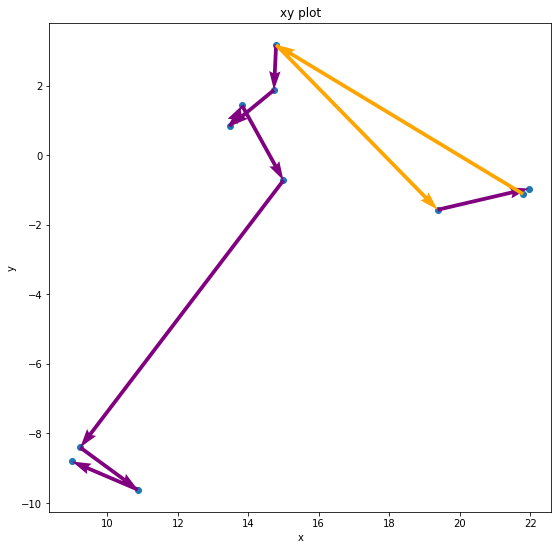

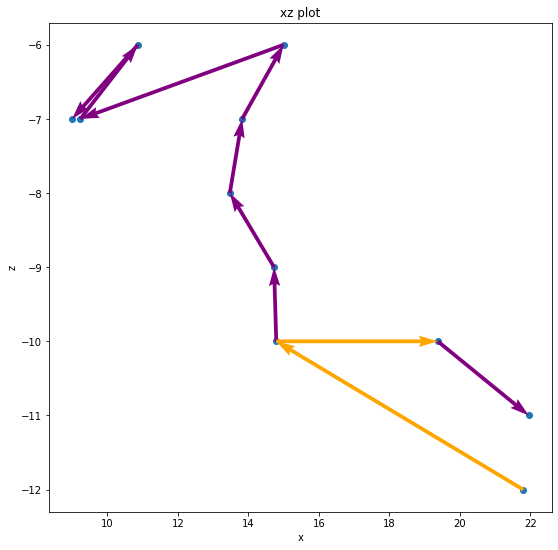

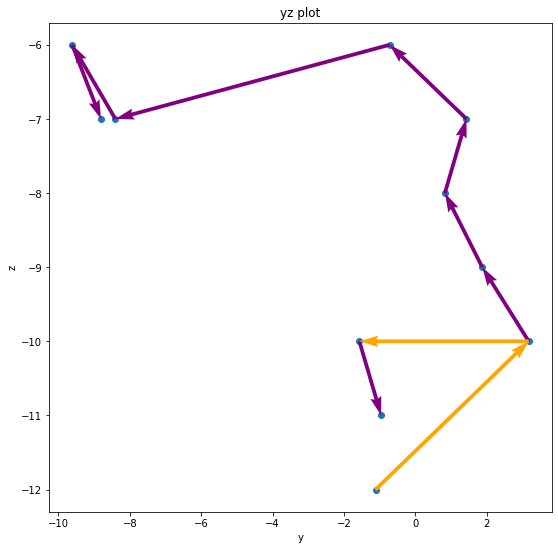

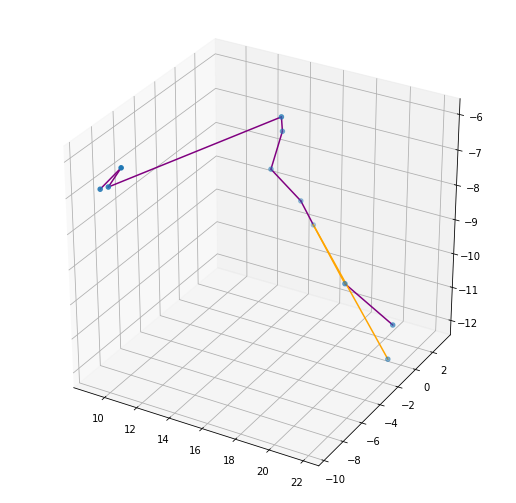

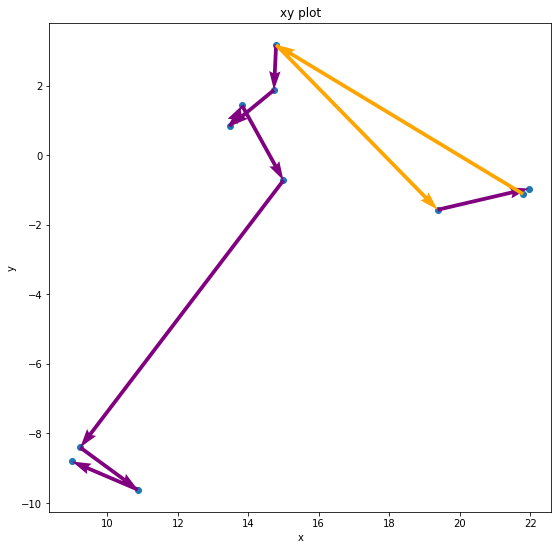

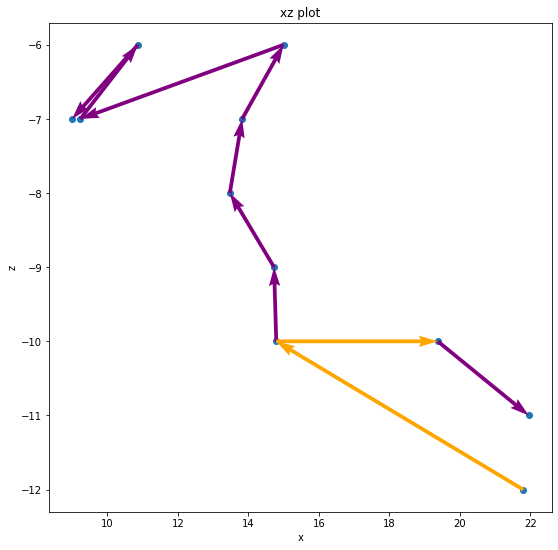

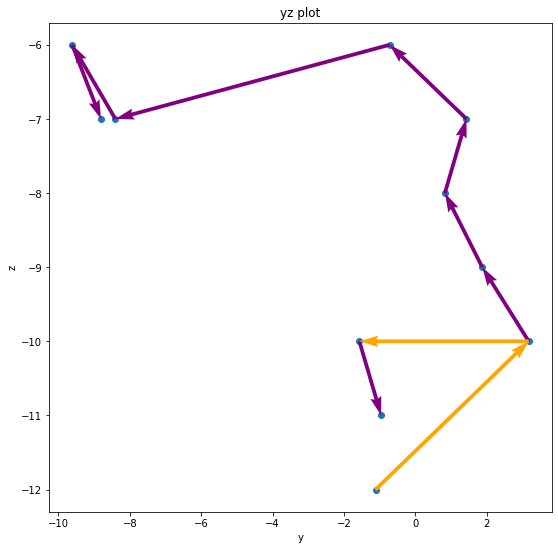

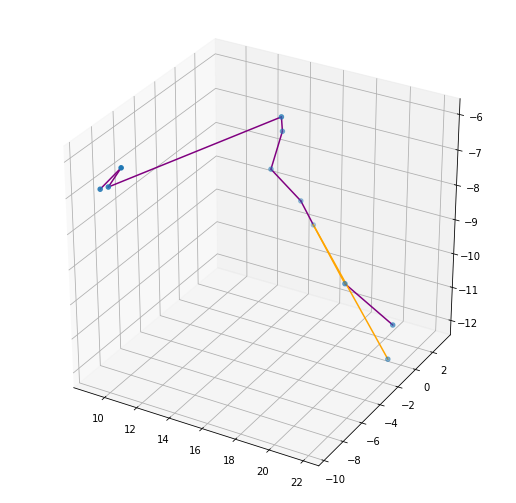

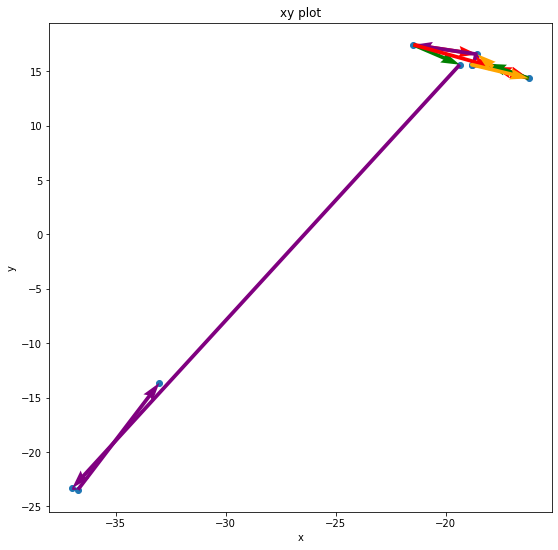

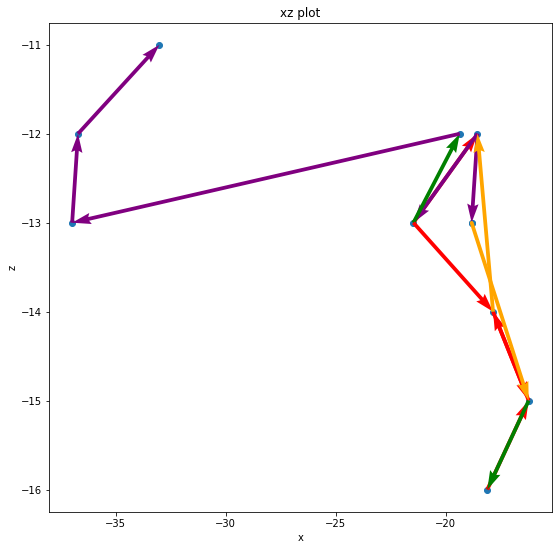

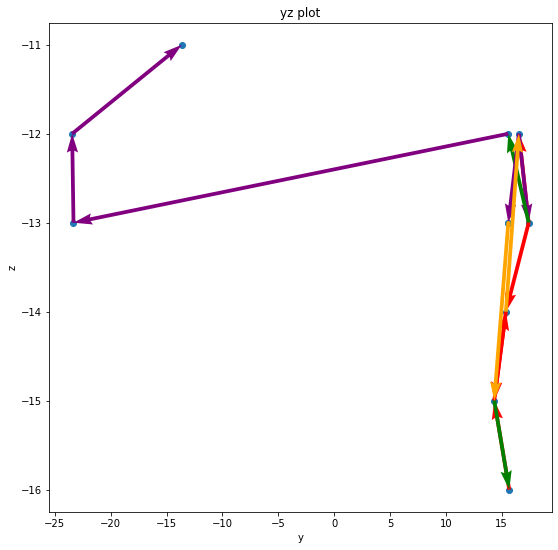

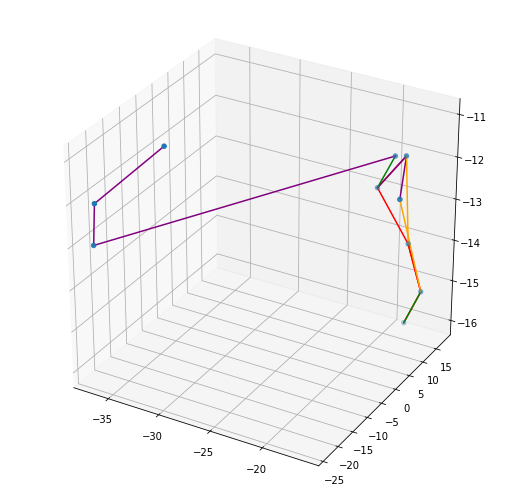

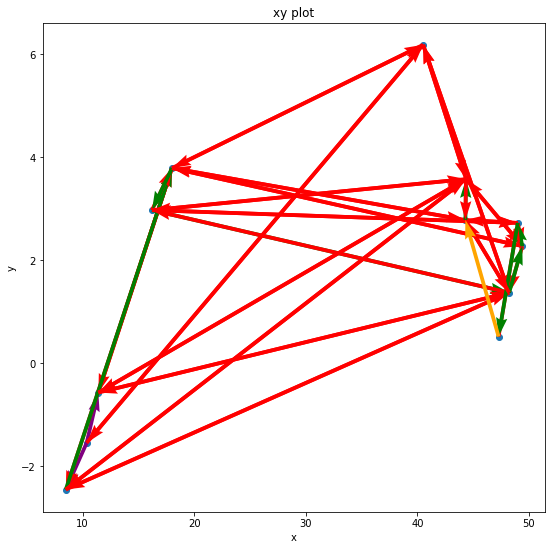

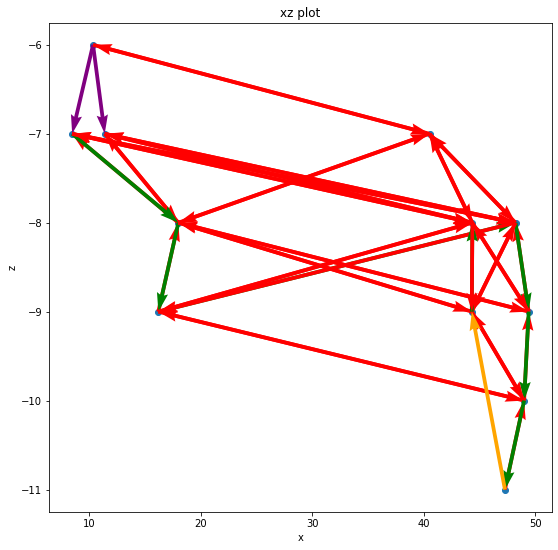

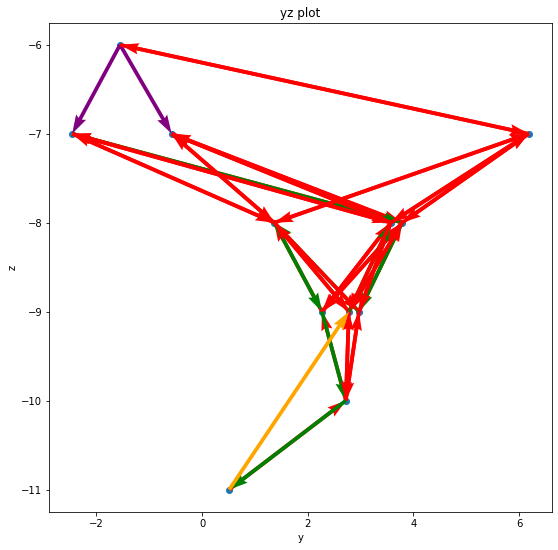

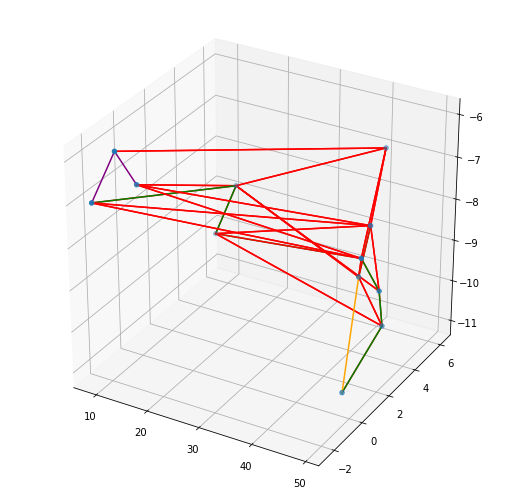

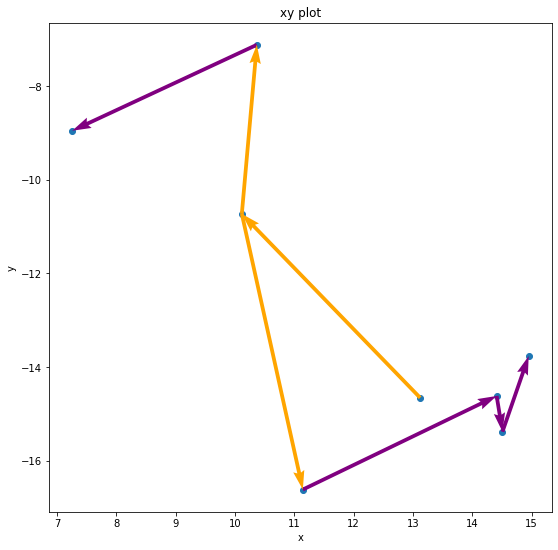

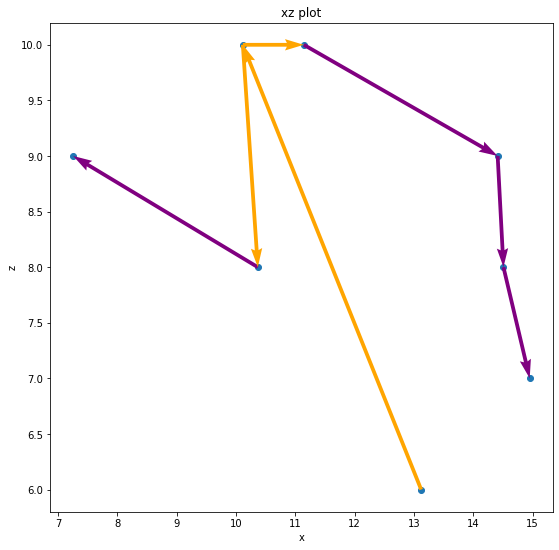

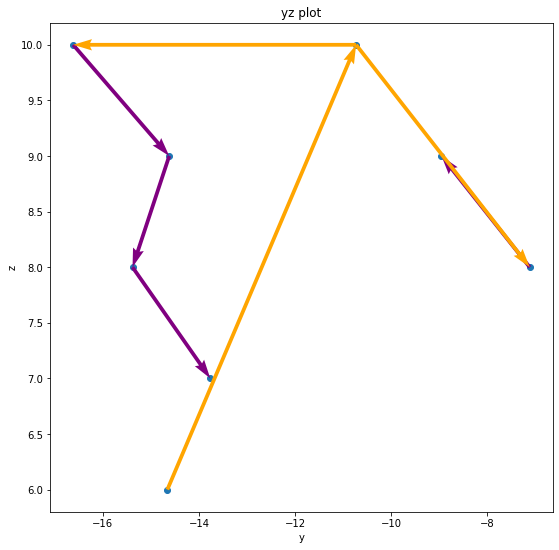

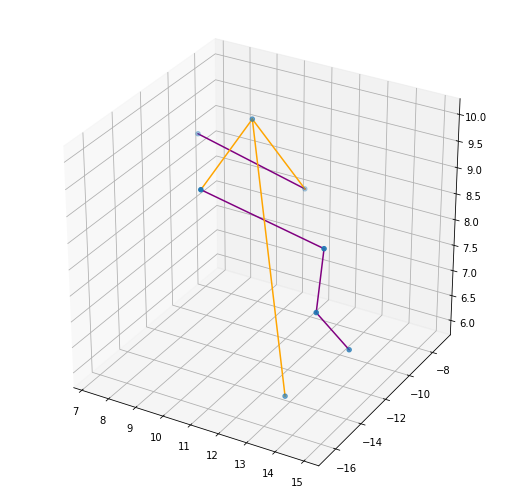

In [2]:
###################################################################################################
# Step 7: Evaluating and Visualizing the network
###################################################################################################

#Locals
from visualization import GraphVisualizer

viz = GraphVisualizer(summary, test_labels, test_True_Ri, test_True_Ro, OutputDirectory)
viz.plot_sample(random.randint(0, test_labels.shape[0]-1))
viz.plot_sample(random.randint(0, test_labels.shape[0]-1))
viz.plot_sample(random.randint(0, test_labels.shape[0]-1))
viz.plot_sample(random.randint(0, test_labels.shape[0]-1))
viz.plot_sample(random.randint(0, test_labels.shape[0]-1))

# Code from vizualization.py (for debugging)

In [178]:
import matplotlib.pyplot as plt
import numpy as np

def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


def draw_vertices_xy(points):
    plt.plot(points[:, 0], points[:, 1], 'o', c='black')


def draw_edge_xy(ptA, ptB, color="blue"):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    plt.plot(x_coords, y_coords, color)[0]


def draw_edge_xyz(ptA, ptB, color="blue"):
    x_coords = np.array([ptA[0], ptB[0]])
    y_coords = np.array([ptA[1], ptB[1]])
    z_coords = np.array([ptA[2], ptB[2]])
    plt.plot(x_coords, y_coords, z_coords, color)[0]
    

def draw_vector_2d(ptA, ptB, color="blue"):
    plt.quiver(
        ptA[0], ptA[1], # start point
        ptB[0] - ptA[0], ptB[1]-ptA[1], # direction
        scale=1, angles='xy', scale_units='xy', color=color
    )


def draw_vector_3d(ptA, ptB, color="blue"):
    plt.quiver(
        ptA[0], ptA[1], ptA[2], # start point
        ptB[0] - ptA[0], ptB[1]-ptA[1], ptB[2]-ptA[2], # direction
        color=color,
        arrow_length_ratio=0.05,
    )


def filter_position(pos):
    """
    Filters out padded rows
    """
    pos = np.array(pos)
    new_pos = []
    for i in range(len(pos)):
        row = pos[i]
        print
        if not np.any(row):
            if i == len(pos) - 1: # last point
                break
            elif not np.any(pos[i+1]): # next point is also zero
                break
        new_pos.append(row)
    
    new_pos = np.array(new_pos)
    return new_pos


"""
pos is (max_hits, 3) containing XYZ
Rin, Rout is (max_hits, max_edges)
predicted_edges, generated_edges is (1, max_edges), True if actually present
axis is tuple of the 2 axis to plot
"""
def draw_2d_plot(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro, axis=(0, 1)):
    fig = plt.figure(figsize=(9, 9))
    new_pos = filter_position(pos)
    plt.scatter(new_pos[:, axis[0]], new_pos[:, axis[1]])
    
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = np.array([pos[ptA_idx][axis[0]], pos[ptA_idx][axis[1]]])
            ptB = np.array([pos[ptB_idx][axis[0]], pos[ptB_idx][axis[1]]])
            
            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
#                 draw_edge_xy(ptA, ptB, color)
                draw_vector_2d(ptA, ptB, color)
    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        pointA = [ptA[axis[0]], ptA[axis[1]]]
        ptB = pos[pair[1]]
        pointB = [ptB[axis[0]], ptB[axis[1]]]
#         draw_edge_xy(pointA, pointB, "orange")
        draw_vector_2d(pointA, pointB, "orange")
    
    axis_dictionary = {0:'x', 1:'y', 2:'z'}
    x_label = axis_dictionary[axis[0]]
    y_label = axis_dictionary[axis[1]]
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(x_label+y_label+" plot")

#     plt.savefig(OutputDirectory +'/test.png')

"""
pos is (max_hits, 3) containing XYZ
Rin, Rout is (max_hits, max_edges)
predicted_edges, generated_edges is (1, max_edges), True if actually present
"""
def draw_3d_plot(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    new_pos = filter_position(pos)
    ax.scatter(new_pos[:, 0], new_pos[:, 1], new_pos[:, 2])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]

            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
                draw_edge_xyz(ptA, ptB, color)
    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        ptB = pos[pair[1]]
        draw_edge_xyz(ptA, ptB, "orange")


def draw_3d_arrows(pos, Rin, Rout, predicted_edges, generated_edges, True_Ri, True_Ro):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
    num_edges = Rin.shape[1]
    for edge_idx in range(num_edges):
        
        # checking if edge or padding
        if sum(Rin[:, edge_idx]) != 0:
            ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
            ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]
            
            ptA = pos[ptA_idx]
            ptB = pos[ptB_idx]

            color = edge_color(edge_idx, predicted_edges, generated_edges)
            if color is not None:
                draw_vector_3d(ptA, ptB, color)
#                 ax.annotate("", xy=ptB, xytext=ptB-ptA, arrowprops=dict(arrowstyle="->"))

    
    # Script error
    pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
    for pair in pt_indices:
        ptA = pos[pair[0]]
        ptB = pos[pair[1]]
        draw_edge_xyz(ptA, ptB, "orange")


'''
for edge in edge_labels
    if predicted true and it's in the event
        color edge green
    if predicted true and it's not in the event
        color edge red
    if predicted false and it's in the event
        color edge purple
    if predicted false and it's not in the event
        don't draw the edge
script error:
an edge in the event is not caught by the manual connection script
look through the edges in event
    if an edge is in the event and not in the manually connected graph -
        color edge orange
'''
def edge_color(edge_idx, predicted_edges, generated_edges):
    if predicted_edges[edge_idx] == True:
        if generated_edges[edge_idx] == True:
            color = 'green'
        else:
            color = 'red'
    else:
        if generated_edges[edge_idx] == True:
            color = 'purple'
        else:
            color = None
    return color


def compare_True_Manual_edges(Man_Ri, Man_Ro, True_Ri, True_Ro):
    pt_indices = []
    for true_edge_idx in range(True_Ri.shape[1]):
        ptA_idx = np.nonzero(True_Ro[:, true_edge_idx])[0][0]
        ptB_idx = np.nonzero(True_Ri[:, true_edge_idx])[0][0]
        
        edge_found = False
        
        A_row = Man_Ro[ptA_idx]
        for e_idx in range(len(A_row)):
            if A_row[e_idx] == 1:
                if Man_Ri[ptB_idx][e_idx] == 1:
                    edge_found = True
                    break
        
        if not edge_found:
            pt_indices.append([ptA_idx, ptB_idx])
    
    return pt_indices

In [179]:
class GraphVisualizer(object):
    axis_dictionary = {0:'x', 1:'y', 2:'z'}
    
    def __init__(self, summary, labels, True_Ri, True_Ro, OutputDir, figure_size=(9, 9)):
        self.summary = summary
        self.labels = labels
        self.True_Ri = True_Ri
        self.True_Ro = True_Ro
        self.OutputDir = OutputDir
        self.figure_size = figure_size
        
        # default batch index
        self.batch_idx = len(summary['X']) - 1


    def draw_2d(self, sample_idx, batch_idx=None, axis=(0,1), filename=None, save=True):
        if batch_idx == None:
            batch_idx = self.batch_idx
        pos = np.array(self.summary['X'][batch_idx][sample_idx]) 
        
        # Might want to convert everything to numpy?
        Rin = self.summary['Ri'][batch_idx][sample_idx]
        Rout = self.summary['Ro'][batch_idx][sample_idx]
        predicted_edges = self.summary['Edge_Labels'][batch_idx][sample_idx]
        generated_edges = self.labels[sample_idx]
        True_Ri = self.True_Ri[sample_idx]
        True_Ro = self.True_Ro[sample_idx]
      
        fig = plt.figure(figsize=self.figure_size)
        
        # Filtering out padded rows, plotting points
        new_pos = filter_position(pos)
        plt.scatter(new_pos[:, axis[0]], new_pos[:, axis[1]])

        num_edges = Rin.shape[1]
        for edge_idx in range(num_edges):

            # checking if edge or padding
            if sum(Rin[:, edge_idx]) != 0:
                ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
                ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]

                ptA = np.array([pos[ptA_idx][axis[0]], pos[ptA_idx][axis[1]]])
                ptB = np.array([pos[ptB_idx][axis[0]], pos[ptB_idx][axis[1]]])

                color = edge_color(edge_idx, predicted_edges, generated_edges)
                if color is not None:
                    # draw_edge_xy(ptA, ptB, color)
                    draw_vector_2d(ptA, ptB, color)

        # Script error
        pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
        for pair in pt_indices:
            ptA = pos[pair[0]]
            pointA = [ptA[axis[0]], ptA[axis[1]]]
            ptB = pos[pair[1]]
            pointB = [ptB[axis[0]], ptB[axis[1]]]
            # draw_edge_xy(pointA, pointB, "orange")
            draw_vector_2d(pointA, pointB, "orange")

        
        x_label = GraphVisualizer.axis_dictionary[axis[0]]
        y_label = GraphVisualizer.axis_dictionary[axis[1]]
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(x_label+y_label+" plot")
        
        # Saving plot
        if save:
            if filename == None:
                filename = "{}{}_plot_{}_{}".format(x_label, y_label, batch_idx, sample_idx)
            plt.savefig(self.OutputDir +'/' + filename)
    
    
    def draw_3d(self, sample_idx, batch_idx=None, filename=None, save=True, arrow=False):
        if batch_idx == None:
            batch_idx = self.batch_idx
        pos = np.array(self.summary['X'][batch_idx][sample_idx]) 
        
        # Might want to convert everything to numpy?
        Rin = self.summary['Ri'][batch_idx][sample_idx]
        Rout = self.summary['Ro'][batch_idx][sample_idx]
        predicted_edges = self.summary['Edge_Labels'][batch_idx][sample_idx]
        generated_edges = self.labels[sample_idx]
        True_Ri = self.True_Ri[sample_idx]
        True_Ro = self.True_Ro[sample_idx]
      
        fig = plt.figure(figsize=self.figure_size)
        ax = fig.add_subplot(111, projection='3d')
        
        new_pos = filter_position(pos)
        ax.scatter(new_pos[:, 0], new_pos[:, 1], new_pos[:, 2])
        
        num_edges = Rin.shape[1]
        for edge_idx in range(num_edges):

            # checking if edge or padding
            if sum(Rin[:, edge_idx]) != 0:
                ptA_idx = np.nonzero(Rout[:, edge_idx])[0][0]
                ptB_idx = np.nonzero(Rin[:, edge_idx])[0][0]

                ptA = pos[ptA_idx]
                ptB = pos[ptB_idx]

                color = edge_color(edge_idx, predicted_edges, generated_edges)
                if color is not None:
                    if arrow:
                        draw_vector_3d(ptA, ptB, color)
                        # ax.annotate("", xy=ptB, xytext=ptB-ptA, arrowprops=dict(arrowstyle="->"))
                    else:
                        draw_edge_xyz(ptA, ptB, color)


        # Script error
        pt_indices = compare_True_Manual_edges(Rin, Rout, True_Ri, True_Ro)
        for pair in pt_indices:
            ptA = pos[pair[0]]
            ptB = pos[pair[1]]
            if arrow:
                draw_vector_3d(ptA, ptB, "orange")
            else:
                draw_edge_xyz(ptA, ptB, "orange")
            
        # Saving plot
        if save:
            if filename == None:
                filename = "3d_plot_{}_{}".format(batch_idx, sample_idx)
            plt.savefig(self.OutputDir +'/' + filename)


    def plot_sample(self, sample_idx, batch_idx=None, save=True):
        if batch_idx == None:
            batch_idx = self.batch_idx
        self.draw_2d(sample_idx, batch_idx=batch_idx, axis=(0, 1), save=save)
        self.draw_2d(sample_idx, batch_idx=batch_idx, axis=(0, 2), save=save)
        self.draw_2d(sample_idx, batch_idx=batch_idx, axis=(1, 2), save=save)
        
        self.draw_3d(sample_idx, batch_idx=batch_idx, save=save)
    
    

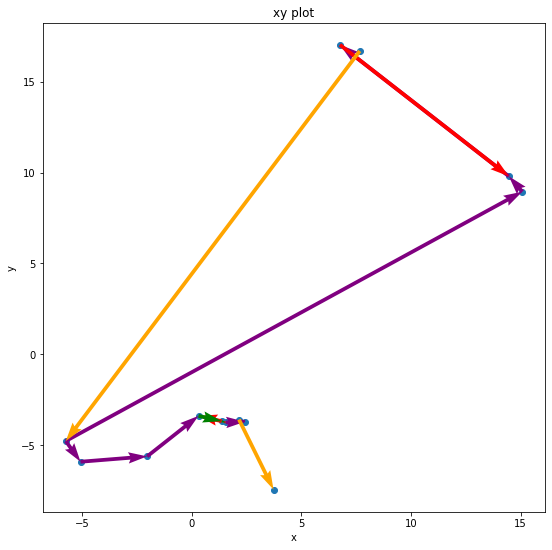

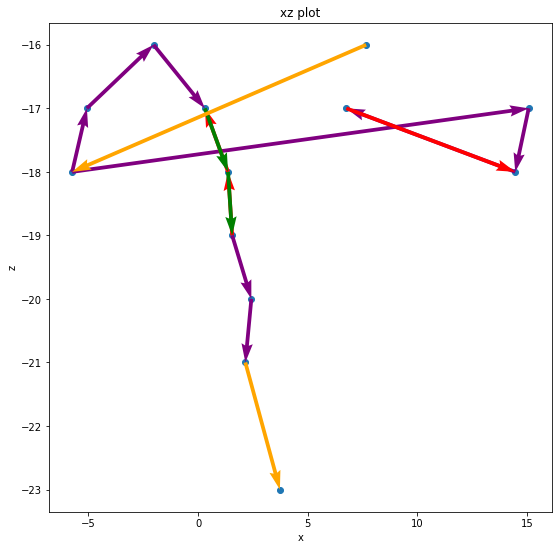

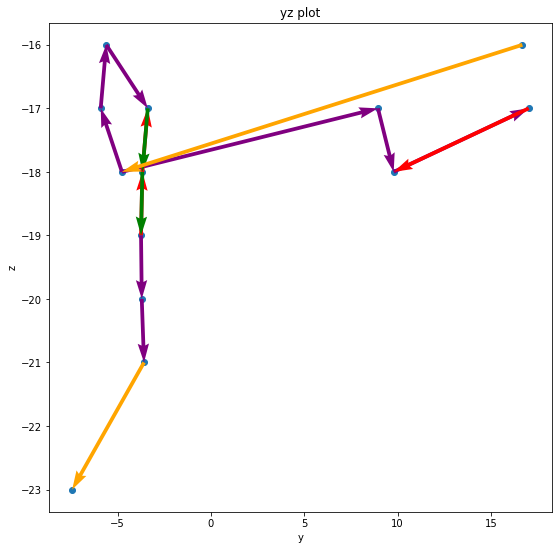

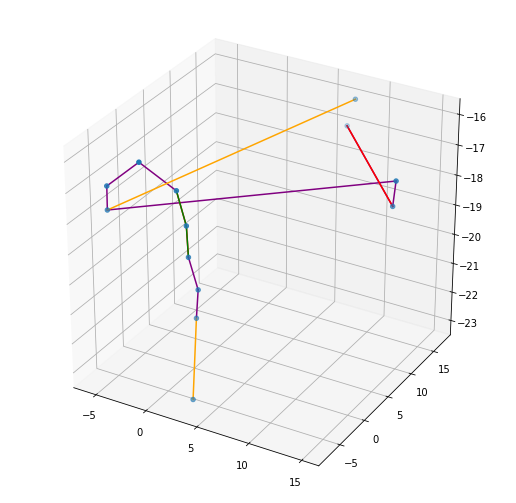

In [180]:
viz = GraphVisualizer(summary, test_labels, test_True_Ri, test_True_Ro, OutputDirectory)
viz.plot_sample(10, save=False)

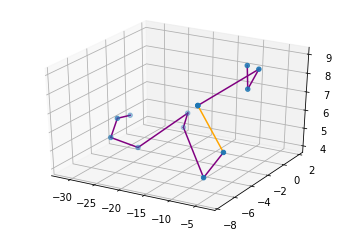

In [181]:
b_idx = 4 # batch_idx, recommended 4
s_idx = 3 # sample_idx, can change to plot different events

draw_3d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx]
            )

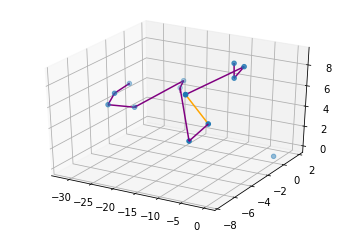

In [182]:
draw_3d_arrows(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx]
            )

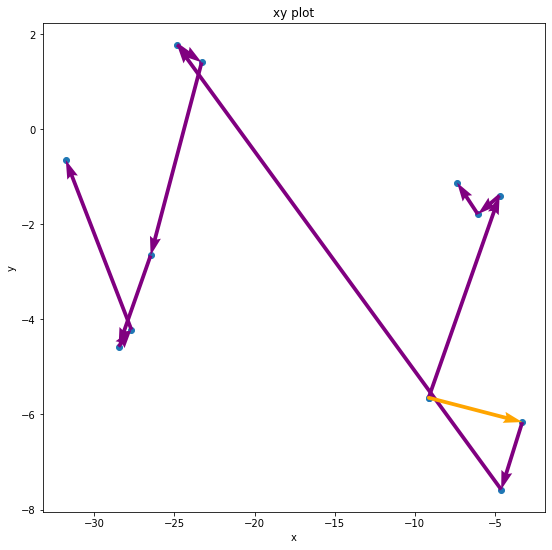

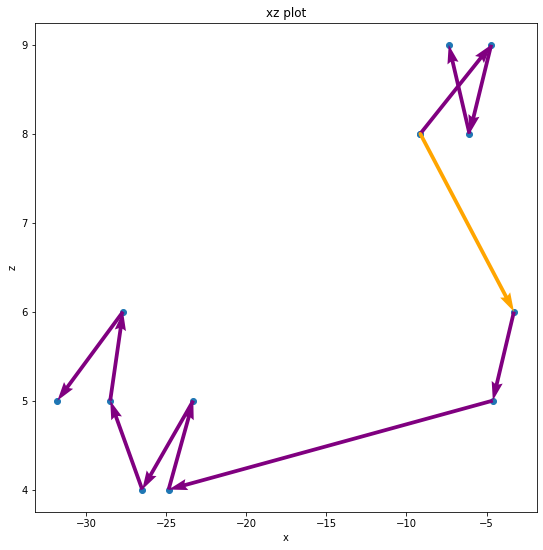

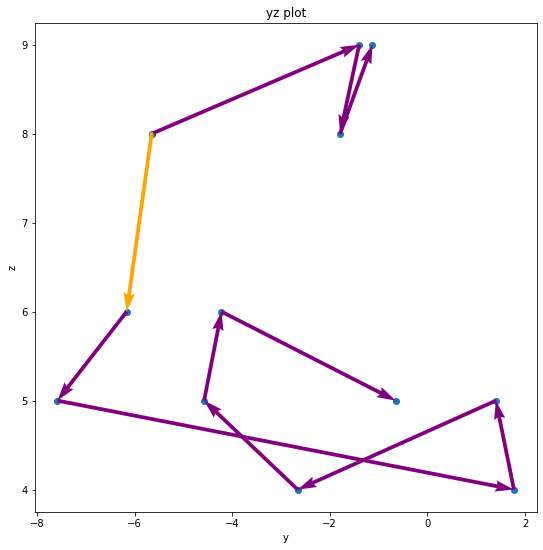

In [130]:
#XY
draw_2d_plot(np.array(summary['X'][b_idx][s_idx]),
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 1))

#XZ
draw_2d_plot(np.array(summary['X'][b_idx][s_idx]),
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 2))

#YZ
draw_2d_plot(np.array(summary['X'][b_idx][s_idx]),
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(1, 2))

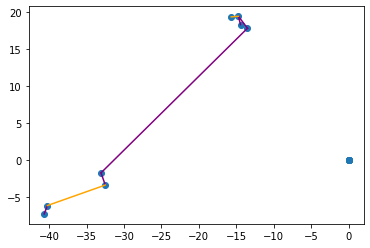

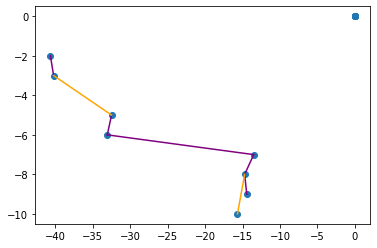

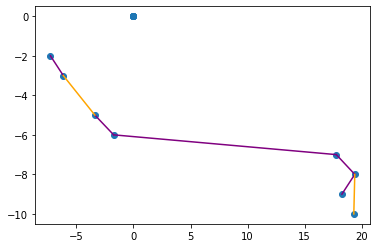

In [28]:
#XY
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 1))

#XZ
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(0, 2))

#YZ
draw_2d_plot(summary['X'][b_idx][s_idx],
             summary['Ri'][b_idx][s_idx],
             summary['Ro'][b_idx][s_idx],
             summary['Edge_Labels'][b_idx][s_idx],
             test_labels[s_idx],
             test_True_Ri[s_idx],
             test_True_Ro[s_idx],
             axis=(1, 2))

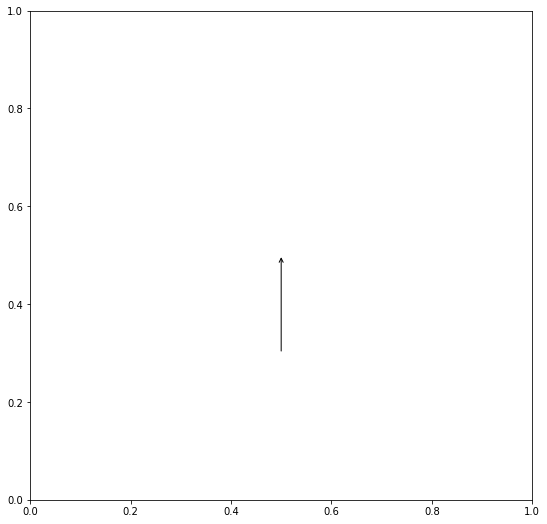

In [120]:
import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(6, 9))
# ax = plt.axes()
fig, ax = plt.subplots(figsize=(9, 9))
# plt.arrow(1, 1, 2, 2, head_width=0.05, head_length=0.1, fc='k', ec='k')
# ax.arrow()
plt.annotate("", xy=(0.5, 0.5), xytext=(0.5, 0.3), arrowprops=dict(arrowstyle="->"))
# plt.quiver(1, 1, 2, 2, scale=1)
plt.show()

In [121]:
OutputDirectory

'Results_20200430_165552'